#### Load packages

In [ ]:
import os
import scvi
import scanpy as sc
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
sc.set_figure_params(dpi=300)

#### check files

In [ ]:
ag_files = [file for file in os.listdir('./') if 'Ag' in file]
ag_files

['AgOFF_CTL', 'AgOFF_CXCR2', 'AgON_CTL', 'AgON_CXCR2']

In [ ]:
Regions = ['Region1','Region2','Region3']
Regions

['Region1', 'Region2', 'Region3']

In [ ]:
d={}
varnames=[]
for i in ag_files:
    for j in range(3):  # for 3 regions 
        var = 'adata_'+str(i)+'_'+Regions[j]
        d[var] = sc.read_10x_h5('./'+str(i)+'/'+Regions[j]+'_cell_feature_matrix.h5')
        df = pd.read_csv('./'+str(i)+'/'+Regions[j]+'_cells.csv.gz')
        df.set_index( d['adata_'+str(i)+'_'+Regions[j]].obs_names, inplace=True)
        d[var].obs = df.copy()
        d[var].obsm["spatial"] =  d[var].obs[["x_centroid", "y_centroid"]].copy().to_numpy()
        varnames.append(str(var))

In [ ]:
varnames

['adata_AgOFF_CTL_Region1',
 'adata_AgOFF_CTL_Region2',
 'adata_AgOFF_CTL_Region3',
 'adata_AgOFF_CXCR2_Region1',
 'adata_AgOFF_CXCR2_Region2',
 'adata_AgOFF_CXCR2_Region3',
 'adata_AgON_CTL_Region1',
 'adata_AgON_CTL_Region2',
 'adata_AgON_CTL_Region3',
 'adata_AgON_CXCR2_Region1',
 'adata_AgON_CXCR2_Region2',
 'adata_AgON_CXCR2_Region3']

In [ ]:
# concatenate variables 
adata_concat = d[varnames[0]].concatenate(d[varnames[1]],d[varnames[2]],d[varnames[3]],
                                          d[varnames[4]],d[varnames[5]],d[varnames[6]],
                                          d[varnames[7]],d[varnames[8]],d[varnames[9]],
                                          d[varnames[10]],d[varnames[11]],batch_key="sample")

In [ ]:
adata_concat.obs  # unintegrated, just the combined(merged) object

cell_id   x_centroid   y_centroid  transcript_counts  \
aaaafgkj-1-0   aaaafgkj-1  1223.831787  1705.984131                784   
aaabamno-1-0   aaabamno-1  1239.539551  1698.213867                445   
aaabbhfk-1-0   aaabbhfk-1  1251.154663  1690.652588                234   
aaacfjeo-1-0   aaacfjeo-1  1260.888062  1700.416016                656   
aaacmofg-1-0   aaacmofg-1  1269.192871  1685.601318                325   
...                   ...          ...          ...                ...   
oinigofd-1-11  oinigofd-1  4227.795898  4392.556641                175   
oinijeoo-1-11  oinijeoo-1  4233.199219  4402.072754                 50   
oinjenkb-1-11  oinjenkb-1  4244.692383  4407.161621                325   
oinjipmm-1-11  oinjipmm-1  4225.563965  4413.300781                197   
oinkhfhk-1-11  oinkhfhk-1  5245.891113  6645.369629                  2   

               control_probe_counts  control_codeword_counts  \
aaaafgkj-1-0                      0                        0   
aaabamno-1-0                      0                        1   
aaabbhfk-1-0                      0                        0   
aaacfjeo-1-0                      0                        0   
aaacmofg-1-0                      0                        0   
...                             ...                      ...   
oinigofd-1-11                     0                        0   
oinijeoo-1-11                     0                        0   
oinjenkb-1-11                     0                        0   
oinjipmm-1-11                     0                        0   
oinkhfhk-1-11                     0                        0   

               unassigned_codeword_counts  deprecated_codeword_counts  \
aaaafgkj-1-0                            1                           0   
aaabamno-1-0                            0                           0   
aaabbhfk-1-0                            0                           0   
aaacfjeo-1-0                            0                           0   
aaacmofg-1-0                            0                           0   
...                                   ...                         ...   
oinigofd-1-11                           0                           0   
oinijeoo-1-11                           0                           0   
oinjenkb-1-11                           0                           0   
oinjipmm-1-11                           0                           0   
oinkhfhk-1-11                           0                           0   

               total_counts   cell_area  nucleus_area sample  
aaaafgkj-1-0            785  704.979401     33.957501      0  
aaabamno-1-0            446  347.341888     42.943595      0  
aaabbhfk-1-0            234  114.877504     25.513282      0  
aaacfjeo-1-0            656  296.947511     41.182501      0  
aaacmofg-1-0            325  137.455630     24.745626      0  
...                     ...         ...           ...    ...  
oinigofd-1-11           175  501.505331     36.170158     11  
oinijeoo-1-11            50   34.815470      9.437657     11  
oinjenkb-1-11           325  363.191732     30.390157     11  
oinjipmm-1-11           197  425.146109     17.520626     11  
oinkhfhk-1-11             2  878.198782      9.708594     11  

[1503051 rows x 12 columns]

In [ ]:
# standard pre-processing
sc.pp.calculate_qc_metrics(adata_concat, percent_top=None, log1p=False, inplace=True) 

# (optional)
sc.pp.filter_cells(adata_concat, min_genes=5)  # filter out cells that do not contain at least 5 genes (very much low threshold, compared to scRNA)
sc.pp.filter_genes(adata_concat, min_cells=5)  # filter out genes that are at least in 5 cells -> all 295 genes are in more than 5 cells 

adata_concat.layers['counts']=adata_concat.X.copy()

sc.pp.normalize_total(adata_concat, inplace=True)
sc.pp.log1p(adata_concat) #change to log counts
adata_concat.raw = adata_concat #save raw data before processing values and further filtering

In [ ]:
adata_concat.obs.sort_values('n_genes')

cell_id   x_centroid   y_centroid  transcript_counts  \
hfklaeof-1-7   hfklaeof-1  2973.325684  3595.013672                  5   
gphcpabk-1-11  gphcpabk-1  2075.983643  4064.126221                  5   
koighmnp-1-9   koighmnp-1  1801.460083  1354.986816                  6   
cnjaolaj-1-10  cnjaolaj-1  4041.607666  4578.684570                  5   
fgfmgoei-1-9   fgfmgoei-1  3645.986816  2624.620117                  5   
...                   ...          ...          ...                ...   
gihpgpec-1-2   gihpgpec-1  3368.945312  3775.898193               1602   
bmahjbnd-1-1   bmahjbnd-1  2880.615723  4704.590332               1492   
hnoknelh-1-2   hnoknelh-1  4996.935547  1299.684326               2193   
afcpjilo-1-2   afcpjilo-1  1562.480713  2557.368164                821   
bidbafgb-1-1   bidbafgb-1  2015.923462  2363.082520               2112   

               control_probe_counts  control_codeword_counts  \
hfklaeof-1-7                      0                        0   
gphcpabk-1-11                     0                        0   
koighmnp-1-9                      0                        0   
cnjaolaj-1-10                     0                        0   
fgfmgoei-1-9                      0                        0   
...                             ...                      ...   
gihpgpec-1-2                      0                        0   
bmahjbnd-1-1                      0                        0   
hnoknelh-1-2                      0                        0   
afcpjilo-1-2                      0                        0   
bidbafgb-1-1                      0                        0   

               unassigned_codeword_counts  deprecated_codeword_counts  \
hfklaeof-1-7                            0                           0   
gphcpabk-1-11                           0                           0   
koighmnp-1-9                            0                           0   
cnjaolaj-1-10                           0                           0   
fgfmgoei-1-9                            0                           0   
...                                   ...                         ...   
gihpgpec-1-2                            0                           0   
bmahjbnd-1-1                            0                           0   
hnoknelh-1-2                            0                           0   
afcpjilo-1-2                            0                           0   
bidbafgb-1-1                            0                           0   

               total_counts   cell_area  nucleus_area sample  \
hfklaeof-1-7            5.0   22.442657      9.482813      7   
gphcpabk-1-11           5.0   32.918907     15.082188     11   
koighmnp-1-9            6.0   29.532189     21.539532      9   
cnjaolaj-1-10           5.0   13.005000      7.405625     10   
fgfmgoei-1-9            5.0   20.591251      9.392500      9   
...                     ...         ...           ...    ...   
gihpgpec-1-2         1602.0  456.078142    233.683602      2   
bmahjbnd-1-1         1492.0  438.738141    221.536571      1   
hnoknelh-1-2         2193.0  901.093001    221.401102      2   
afcpjilo-1-2          821.0  275.995010     92.434847      2   
bidbafgb-1-1         2112.0  937.714722    379.764076      1   

               n_genes_by_counts  n_genes  
hfklaeof-1-7                   5        5  
gphcpabk-1-11                  5        5  
koighmnp-1-9                   5        5  
cnjaolaj-1-10                  5        5  
fgfmgoei-1-9                   5        5  
...                          ...      ...  
gihpgpec-1-2                 152      152  
bmahjbnd-1-1                 153      153  
hnoknelh-1-2                 153      153  
afcpjilo-1-2                 159      159  
bidbafgb-1-1                 160      160  

[1486332 rows x 14 columns]

In [ ]:
adata_concat.shape

(1486332, 295)

### Integration using SCVI

In [ ]:
# SCVI
scvi.model.SCVI.setup_anndata(adata_concat, layer='counts', 
                             categorical_covariate_keys=['sample'],
                             continuous_covariate_keys=['total_counts']) # can take account for different variables
model = scvi.model.SCVI(adata_concat)

In [ ]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
model.train() #may take a while without GPU

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/5: 100%|██████████| 5/5 [22:22<00:00, 293.24s/it, v_num=1, train_loss_step=146, train_loss_epoch=147]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [22:22<00:00, 268.45s/it, v_num=1, train_loss_step=146, train_loss_epoch=147]


In [ ]:
latent = model.get_latent_representation() #this is what you will use to cluster now instead of PCs 

In [ ]:
latent.shape

(1486332, 10)

In [ ]:
adata_concat.obsm['X_scVI'] = latent
adata_concat.layers['scvi_normalized'] = model.get_normalized_expression()

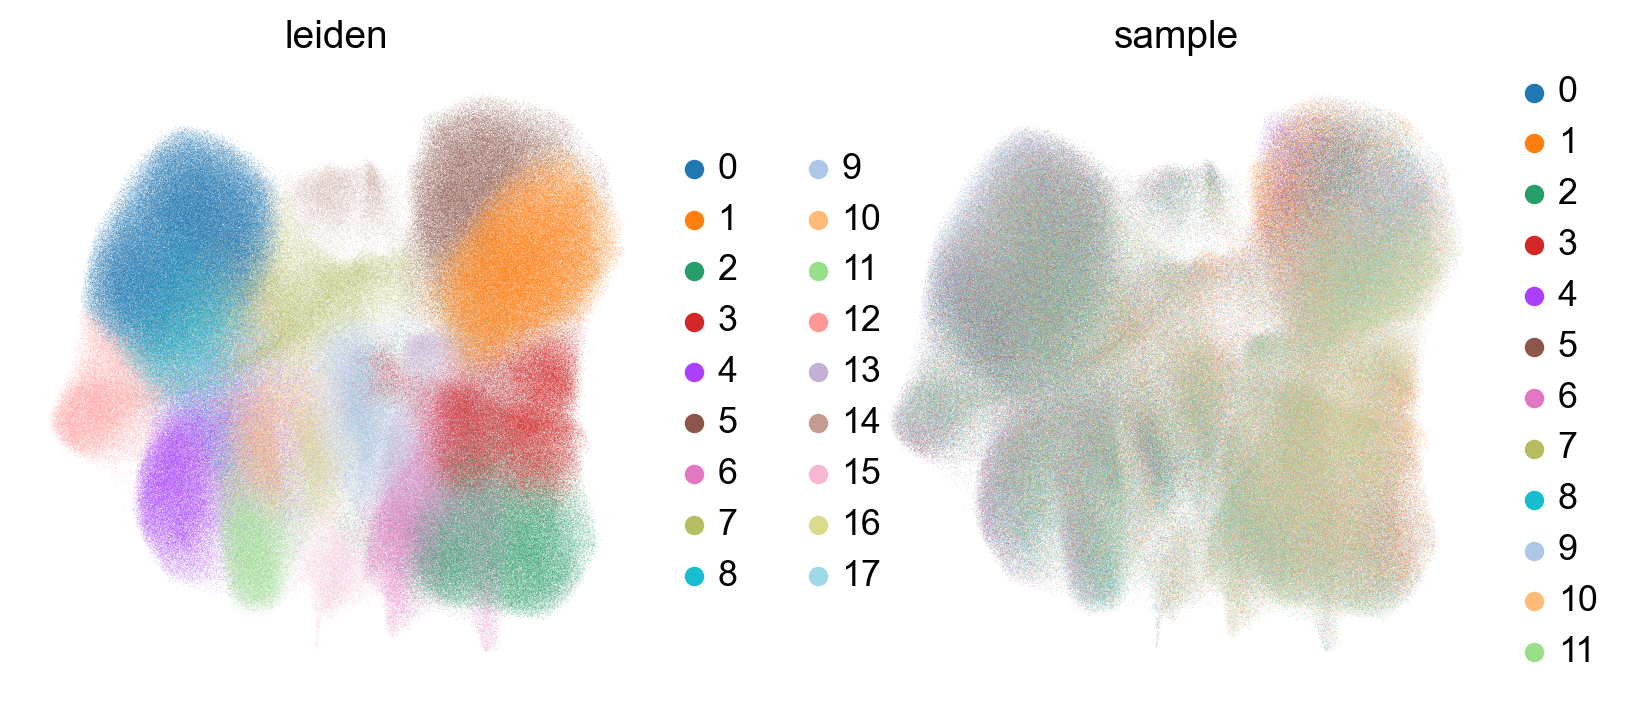

In [ ]:
sc.pp.neighbors(adata_concat, use_rep='X_scVI') 
sc.tl.umap(adata_concat) 
sc.tl.leiden(adata_concat, resolution=1)
sc.pl.umap(adata_concat, color = ['leiden', 'sample'], frameon = False)

In [ ]:
adata_concat.obs['sample']

aaaafgkj-1-0      0
aaabamno-1-0      0
aaabbhfk-1-0      0
aaacfjeo-1-0      0
aaacmofg-1-0      0
                 ..
oinigbjh-1-11    11
oinigofd-1-11    11
oinijeoo-1-11    11
oinjenkb-1-11    11
oinjipmm-1-11    11
Name: sample, Length: 1486332, dtype: category
Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', '11']

In [ ]:
adata_concat.obs['sample'] =adata_concat.obs['sample'].map({
    "0":"AgOFF_CTL",
    "1":"AgOFF_CTL",
    "2":"AgOFF_CTL",
    "3":"AgOFF_CXCR2",
    "4":"AgOFF_CXCR2",
    "5":"AgOFF_CXCR2",
    "6":"AgON_CTL",
    "7":"AgON_CTL",
    "8":"AgON_CTL",
    "9":"AgON_CXCR2",
    "10":"AgON_CXCR2",
    "11":"AgON_CXCR2"})

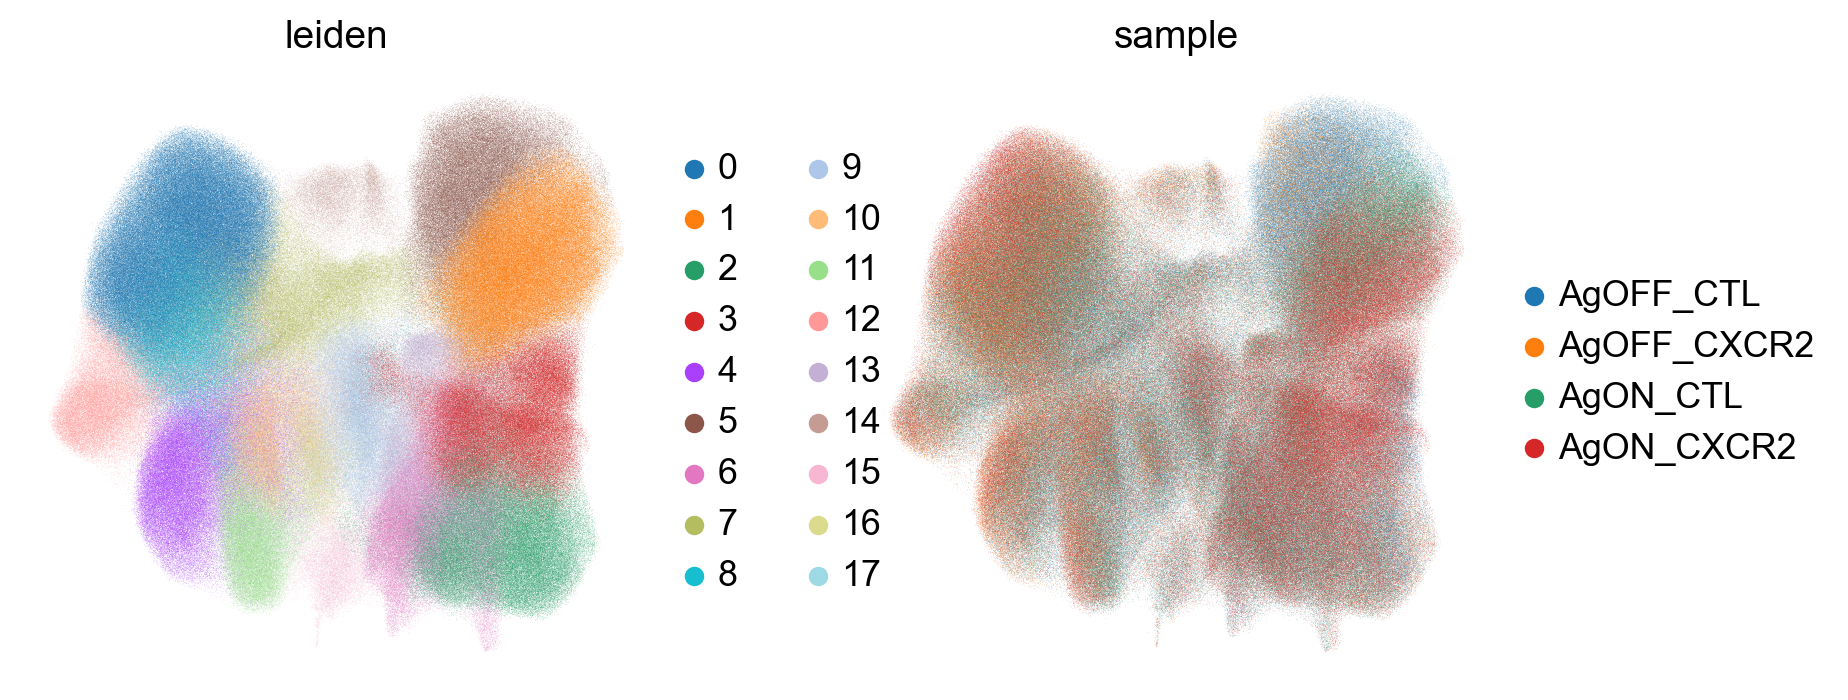

In [ ]:
sc.pl.umap(adata_concat, color = ['leiden', 'sample'], frameon = False)

In [ ]:
#adata_concat.write_h5ad('./output/integrated.h5ad')

In [ ]:
dff = model.differential_expression(groupby='leiden') 

DE...: 100%|██████████| 18/18 [09:11<00:00, 30.67s/it]


In [ ]:
dff

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
Vim        0.9842        0.0158      4.131819  0.000653  0.018210   
Spp1       0.9786        0.0214      3.822732  0.000479  0.016273   
Tlr4       0.9776        0.0224      3.776039  0.000148  0.001777   
Col1a1     0.9764        0.0236      3.722625  0.000113  0.012215   
Timp1      0.9762        0.0238      3.713981  0.000012  0.000922   
...           ...           ...           ...       ...       ...   
Ifitm2     0.7236        0.2764      0.962390  0.002878  0.002764   
Atp6v0c    0.7166        0.2834      0.927658  0.005763  0.007716   
B2m        0.7150        0.2850      0.919793  0.067114  0.056043   
Xbp1       0.7016        0.2984      0.854929  0.005449  0.006007   
Mrpl52     0.6976        0.3024      0.835895  0.002386  0.003009   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
Vim               0.0   0.25 -4.619204   -4.845301  2.336499  ...   0.244228   
Spp1              0.0   0.25 -4.367872   -4.739878  3.874924  ...   0.189583   
Tlr4              0.0   0.25 -3.185120   -3.330455  1.649173  ...   0.026475   
Col1a1            0.0   0.25 -5.016604   -4.924958  4.384082  ...   0.041165   
Timp1             0.0   0.25 -4.851353   -5.186575  3.245744  ...   0.003330   
...               ...    ...       ...         ...       ...  ...        ...   
Ifitm2            0.0   0.25  0.208655    0.112119  0.783656  ...   1.248247   
Atp6v0c           0.0   0.25 -0.354308   -0.339603  0.627859  ...   2.754801   
B2m               0.0   0.25  0.399012    0.256425  0.824253  ...  36.030159   
Xbp1              0.0   0.25 -0.097527   -0.094610  0.650305  ...   2.895971   
Mrpl52            0.0   0.25 -0.329871   -0.329986  0.536335  ...   1.285834   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
Vim       3.631967               0.183565               0.688603   
Spp1      3.804910               0.132375               0.468186   
Tlr4      0.354784               0.025772               0.225985   
Col1a1    1.931012               0.037608               0.348794   
Timp1     0.153271               0.003292               0.091685   
...            ...                    ...                    ...   
Ifitm2    0.783081               0.658217               0.434656   
Atp6v0c   1.982804               0.871503               0.705241   
B2m      16.954884               1.000000               0.940458   
Xbp1      1.704888               0.878934               0.642455   
Mrpl52    0.824320               0.665210               0.469881   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
Vim                  6.181633            180.033417            True   
Spp1                 5.102064            160.935333            True   
Tlr4                 0.702533             16.558363            True   
Col1a1               1.110015            122.619576            True   
Timp1                0.085074              8.554859            True   
...                       ...                   ...             ...   
Ifitm2              24.817430             27.296267           False   
Atp6v0c             55.065151             77.326004           False   
B2m                726.003235            585.548523           False   
Xbp1                59.156471             61.238060           False   
Mrpl52              25.153210             29.637136           False   

         comparison  group1 group2  
Vim       0 vs Rest       0   Rest  
Spp1      0 vs Rest       0   Rest  
Tlr4      0 vs Rest       0   Rest  
Col1a1    0 vs Rest       0   Rest  
Timp1     0 vs Rest       0   Rest  
...             ...     ...    ...  
Ifitm2   17 vs Rest      17   Rest  
Atp6v0c  17 vs Rest      17   Rest  
B2m      17 vs Rest      17   Rest  
Xbp1     17 vs Rest      17   Rest  
Mrpl52   17 vs Rest      17   Rest  

[5310 rows x 22 columns]

In [ ]:
dff.to_csv('allsamples_differential_expression.csv')

In [ ]:
markers = {}
for c in adata_concat.obs.leiden.cat.categories:
    cell_df = dff.loc[dff.group1 == c]
    markers[c] = cell_df.index.tolist()[:5]

In [ ]:
markers

{'0': ['Vim', 'Spp1', 'Tlr4', 'Col1a1', 'Timp1'],
 '1': ['Epcam', 'Muc1', 'Krt20', 'Cxcl5', 'Esrp1'],
 '2': ['Col5a2', 'Col1a1', 'Col3a1', 'Tnc', 'Pdgfrb'],
 '3': ['Cd177', 'Mmp9', 'Cxcr2', 'Itgam', 'Stfa2l1'],
 '4': ['Eng', 'Mrc1', 'Thbd', 'Ets1', 'Pecam1'],
 '5': ['Ifit3', 'Lcp1', 'Esrp1', 'Wdr72', 'Muc1'],
 '6': ['Itgax', 'H2-DMa', 'H2-Ab1', 'Tlr9', 'Ccl22'],
 '7': ['Lcn2', 'Col1a1', 'Col3a1', 'Krt7', 'Krt19'],
 '8': ['Vim', 'Col1a1', 'Spp1', 'Stc1', 'Timp1'],
 '9': ['Apoh', 'Uox', 'Hrg', 'Itgax', 'S100a6'],
 '10': ['Pdgfrb', 'Adamts5', 'Lum', 'Postn', 'Col3a1'],
 '11': ['Clec4f', 'Folr2', 'Cd163', 'Adgre1', 'Wfdc17'],
 '12': ['Spp1', 'Timp1', 'Itgam', 'Mmp9', 'S100a4'],
 '13': ['Cd3e', 'Cd8a', 'Cd8b1', 'Fasl', 'Pdcd1'],
 '14': ['Sema5a', 'Fgfr1', 'Adamts5', 'Pdpn', 'Krt19'],
 '15': ['Pecam1', 'Thbd', 'Adamts5', 'Stc1', 'Zeb1'],
 '16': ['Cd79a', 'Cd19', 'Cd8b1', 'Ccl5', 'Gzma'],
 '17': ['Ifit1', 'Ifit3', 'Rsad2', 'Isg15', 'Cxcl10']}

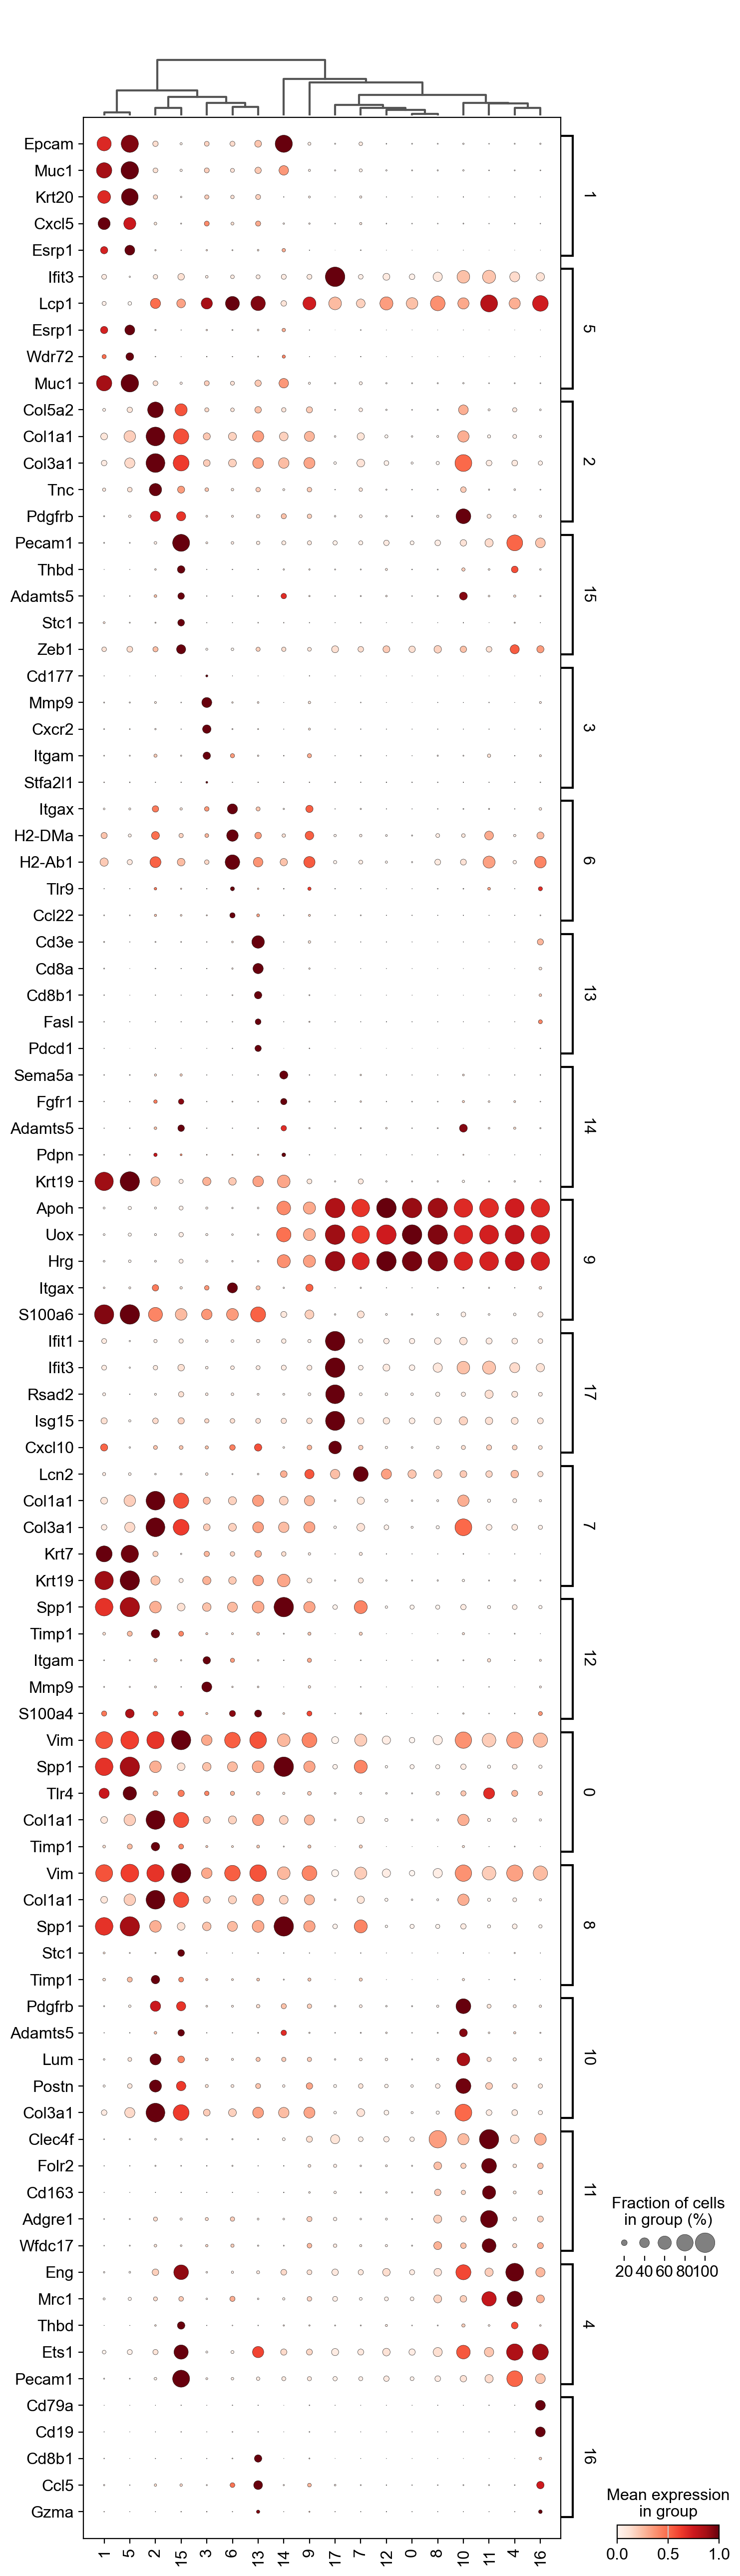

In [ ]:
sc.pl.dotplot(adata_concat, markers, groupby = 'leiden', swap_axes = True,
             use_raw = True, standard_scale = 'var', dendrogram = True)